In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

In [2]:
df = pd.read_csv('feature_engineered_df.csv')
print(df.head())
df_model_survival = df.drop(columns=('timerecurrence'))

   age  eventdeath   survival  timerecurrence  chemo  hormonal  amputation  \
0   43           0  14.817248       14.817248      0         0           1   
1   48           0  14.261465       14.261465      0         0           0   
2   38           0   6.644764        6.644764      0         0           0   
3   50           0   7.748118        7.748118      0         1           0   
4   38           0   6.436687        6.318960      0         0           1   

   diam  posnodes  grade  angioinv  lymphinfil  er_status  histtype_is_1  
0    25  0.000000      2         3           1          1              1  
1    20  0.000000      3         3           1          1              1  
2    15  0.000000      2         1           1          1              1  
3    15  0.693147      2         3           1          1              1  
4    15  0.000000      2         2           1          1              1  


Split the data

In [ ]:
X = df_model_survival.drop(columns=['survival', 'eventdeath'])
y_time = df_model_survival['survival']
y_event = df_model_survival['eventdeath']

X_train, X_test, y_time_train, y_time_test, y_event_train, y_event_test = train_test_split(
    X, y_time, y_event,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=y_event
)

Scale like this to prevent data leakage

In [20]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

COX MODEL

In [21]:
# Combine scaled features with targets into a DataFrame
train_df = X_train_scaled.copy()
train_df['duration'] = y_time_train
train_df['event'] = y_event_train

# Fit the model
cph = CoxPHFitter()
cph.fit(train_df, duration_col='duration', event_col='event')
cph.print_summary()  # See hazard ratios and p-values

<lifelines.CoxPHFitter: fitted with 217 total observations, 156 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 217
number of events observed = 61
   partial log-likelihood = -277.18
         time fit was run = 2025-07-07 23:57:42 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
age           -0.33      0.72      0.15           -0.63           -0.02                0.53                0.98
chemo         -0.19      0.82      0.20           -0.59            0.20                0.55                1.23
hormonal       0.02      1.02      0.17           -0.31            0.35                0.73                1.41
amputation     0.03      1.03      0.14           -0.25            0.31                0.78                1.37
diam           0.05      1.05      0.14           -0.23            0.32                0.80                1.38
posnodes       0.15      1.16      0.19           -0.22            0.52                0.80                1.68
grade          0.94      2.56      0.20            0.55            1.33                1.73                3.79
angioinv       0.31      1.36      0.13            0.05            0.57                1.05                1.76
lymphinfil    -0.36      0.70      0.16           -0.67           -0.05                0.51                0.95
er_status     -0.45      0.64      0.14           -0.72           -0.18                0.49                0.84
histtype_is_1 -0.45      0.64      0.15           -0.73           -0.16                0.48                0.85

               cmp to     z      p  -log2(p)
covariate                                   
age              0.00 -2.12   0.03      4.87
chemo            0.00 -0.95   0.34      1.55
hormonal         0.00  0.10   0.92      0.12
amputation       0.00  0.23   0.82      0.29
diam             0.00  0.34   0.73      0.45
posnodes         0.00  0.80   0.42      1.24
grade            0.00  4.72 <0.005     18.73
angioinv         0.00  2.30   0.02      5.54
lymphinfil       0.00 -2.28   0.02      5.47
er_status        0.00 -3.26 <0.005      9.81
histtype_is_1    0.00 -3.08 <0.005      8.92
---
Concordance = 0.78
Partial AIC = 576.37
log-likelihood ratio test = 60.82 on 11 df
-log2(p) of ll-ratio test = 27.19

TEST

In [22]:
# Predict partial hazards (risk scores) on test set
risk_scores_test = cph.predict_partial_hazard(X_test_scaled)

# Calculate C-index on the test set
c_index_test = concordance_index(
    y_time_test, 
    -risk_scores_test,  # negate so higher risk → shorter survival
    y_event_test
)
print(f"Test set C-index: {c_index_test:.3f}")

Test set C-index: 0.753


TESTING ON A HYPOTETICAL PATIENT

In [23]:
# Example: hypothetical patient profile
new_patient = pd.DataFrame([{
    'age': 39,
    'chemo': 0,
    'hormonal': 1,
    'amputation': 0,
    'diam': 20,
    'posnodes': 0.6931,   # log1p(1) ≈ 0.6931 → 1 positive node
    'grade': 3,
    'angioinv': 2,
    'lymphinfil': 1,
    'er_status': 0,
    'histtype_is_1': 1,
}], columns=X_train_scaled.columns)  # ensure order matches

new_patient_scaled = pd.DataFrame(
    scaler.transform(new_patient),
    columns=new_patient.columns
)

print(new_patient_scaled)

        age    chemo  hormonal  amputation      diam  posnodes     grade  \
0 -0.943581 -0.84182  2.496664   -0.899074 -0.276862  0.145612  1.126174   

   angioinv  lymphinfil  er_status  histtype_is_1  
0   0.39155    -0.46398  -1.675416       0.282138  


In [24]:
risk_score = cph.predict_partial_hazard(new_patient_scaled)
print(f"Predicted risk (partial hazard) for the new patient: {risk_score.values[0]:.4f}")

train_risks = cph.predict_partial_hazard(X_train_scaled)
median_train_risk = train_risks.median()

if risk_score.values[0] > median_train_risk:
    print("This patient has a predicted risk ABOVE the median of your training cohort.")
else:
    print("This patient has a predicted risk BELOW the median of your training cohort.")

Predicted risk (partial hazard) for the new patient: 11.8383
This patient has a predicted risk ABOVE the median of your training cohort.


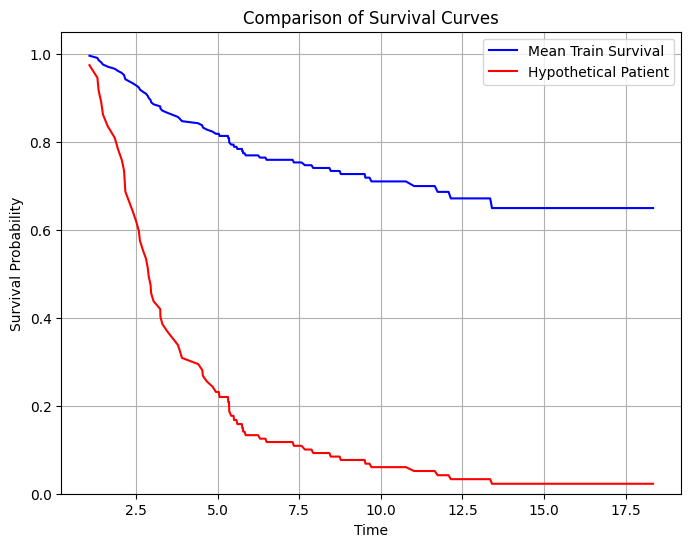

In [25]:
# Predict survival curve
survival_curve = cph.predict_survival_function(new_patient_scaled)

# Mean survival curve over the training set
mean_train_survival = cph.predict_survival_function(X_train_scaled).mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(mean_train_survival.index, mean_train_survival.values, label="Mean Train Survival", color="blue")
plt.plot(survival_curve.index, survival_curve.iloc[:,0], label="Hypothetical Patient", color="red")

plt.title("Comparison of Survival Curves")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()

IMPLEMENT A LLM TO WRITE SUMMARIES USING SHAP

In [ ]:
# Extract coefficients from trained CoxPH model
coef_vector = cph.params_.values
coef_names = cph.params_.index.tolist()

# Check that column order matches
assert list(new_patient_scaled.columns) == coef_names

# Compute linear predictor manually (shows where SHAP comes from)
linear_prediction = np.dot(new_patient_scaled.values, coef_vector)

# Compute SHAP values: feature value * coefficient
shap_values = new_patient_scaled.values * coef_vector  # shape: (1, n_features)

# Put in pandas Series for readability
shap_series = pd.Series(shap_values[0], index=coef_names)

# Rank by absolute SHAP values and get top 4 features
top_features = shap_series.abs().sort_values(ascending=False).head(4).index.tolist()

In [ ]:
# Read survival probability at 5, 10, 15 years (matching dataset's scale)
surv5 = survival_curve.loc[5.037645].values[0] * 100
surv10 = survival_curve.loc[10.020534].values[0] * 100
surv15 = survival_curve.loc[15.077344].values[0] * 100

In [28]:
# Build SHAP explanation lines
shap_lines = []
for feature in top_features:
    shap_val = shap_series[feature]
    shap_lines.append(f"- **{feature} (SHAP {'+' if shap_val >=0 else ''}{shap_val:.2f})**")

# Assemble final prompt
prompt = f"""
A Cox proportional hazards model predicted the patient’s survival curve, estimating a {surv5:.1f}% probability of survival at 
5 years, a {surv10:.1f}% probability at 10 years, and a {surv15:.1f}% probability at 15 years.

The SHAP analysis identified the most influential features contributing to this prognosis:

{chr(10).join(shap_lines)}

Please provide a clinical explanation for these survival probabilities, discussing how each key feature contributes biologically 
to the patient’s predicted outcome. Use professional medical language appropriate for an oncologist or clinical researcher.
"""

print(prompt)


A Cox proportional hazards model predicted the patient’s survival curve, estimating a 23.1% probability of survival at 
5 years, a 6.0% probability at 10 years, and a 2.3% probability at 15 years.

The SHAP analysis identified the most influential features contributing to this prognosis:

- **grade (SHAP +1.06)**
- **er_status (SHAP +0.76)**
- **age (SHAP +0.31)**
- **lymphinfil (SHAP +0.17)**

Please provide a clinical explanation for these survival probabilities, discussing how each key feature contributes biologically 
to the patient’s predicted outcome. Use professional medical language appropriate for an oncologist or clinical researcher.

